# Train a bi-LSTM to predict short entities<br>Adam Klie<br>11/17/2019<br>Script to train a model based on merged entities passed in and training set decided on

#### Import necessry packages

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import spacy
import tensorflow
import keras
from keras.models import Sequential, model_from_json, load_model
from keras.layers import LSTM, Dense, Embedding, Bidirectional
from keras.layers import TimeDistributed
from keras.optimizers import Adam
from sklearn import preprocessing, metrics

/cellar/users/aklie/miniconda3/envs/deep_nlp_cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/cellar/users/aklie/miniconda3/envs/deep_nlp_cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)
/cellar/users/aklie/miniconda3/envs/deep_nlp_cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/cellar/users/aklie/miniconda3/envs/deep_nlp_cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)
Using TensorFlow backend.


In [ ]:
print("Num GPUs Available: ", len(tensorflow.config.experimental.list_physical_devices('GPU')))

#### Helper functions

In [2]:
# Function to build LSTM model.
# embeddings: an mxn matrix of word embeddings with m words and n features for each word (this case is 5443656 x 200)
# shape: parameter split into number of hidden units, 
def compile_lstm(embeddings, shape, settings):  # function definition
    model = Sequential()
    model.add(Embedding(embeddings.shape[0],
                        embeddings.shape[1],
                        input_length=shape['max_length'],
                        trainable=False,
                        weights=[embeddings],
                        mask_zero=True))
    
    #the same dense layer is first applied extract the most useful info from embedding layers
    model.add(TimeDistributed(Dense(shape['nr_hidden'], use_bias=False)))
    model.add(Bidirectional(LSTM(shape['nr_hidden'],
                                 recurrent_dropout=settings['dropout'],
                                 dropout=settings['dropout'])))
    model.add(Dense(shape['nr_class'], activation='sigmoid'))
    model.compile(optimizer=Adam(lr=settings['lr']), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def get_features(docs, max_length):
    docs = list(docs)
    Xs = np.zeros((len(docs), max_length), dtype='int32')
    for i, doc in tqdm(enumerate(docs),total=len(docs)):
        j = 0
        for token in doc:
            ##rever to word vector
            vector_id = token.vocab.vectors.find(key=token.orth)
            if vector_id >= 0:
                Xs[i, j] = vector_id
            else:
                Xs[i, j] = 0
            j += 1
            if j >= max_length:
                break
    return Xs

### 1. Load in data

In [3]:
model_iter = 'simple'

#### Read in the BioSample annotations and build dataframe

In [4]:
# Read in pandas Series from file
SRS_dir = "../data/allSRS_05_15_2018.pickle"
allSRS = pd.read_pickle(SRS_dir)

#### Read in metadata on BioSample entries that will allow us to cap on study

In [5]:
sra_dump_pickle_dir = '../data/sra_dump.pickle'
technical_meta_data_df = pd.read_pickle(sra_dump_pickle_dir)

#### Read in embeddings

In [6]:
nlp = spacy.load('../data/wikipedia-pubmed-and-PMC-w2v')

/cellar/users/aklie/miniconda3/envs/deep_nlp_cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/cellar/users/aklie/miniconda3/envs/deep_nlp_cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)


#### Import merging of entities from file

In [7]:
grouping_df = pd.read_csv('../results/entity_merging_{model}.csv'.format(model = model_iter))
myAttribs = grouping_df.attribute.unique()
myAttribs

array(['SCIENTIFIC_NAME', 'organism', 'Species', 'Organism', 'host',
       'host scientific name', 'host_scientific_name', 'specific host',
       'host organism', 'cell type', 'cell_type', 'source cell type',
       'cell types', 'source_name', 'cell description', 'cell-type',
       'progenitor cell type', 'CellType', 'tissue/cell type',
       'cell subtype', 'cell', 'differentiation status',
       'biomaterial_type', 'cell line source', 'genotype',
       'genotype/variation', 'plant genotype', 'Genotype', 'mutant',
       'ArrayExpress-Genotype', 'host genotype', 'mutation',
       'paternal genotype', 'host_genotype', 'disease', 'diagnosis',
       'cancer type', 'tumor type', 'disease state', 'clinical history',
       'tissue', 'tissue_type', 'organism part', 'tissue type',
       'tissue-type'], dtype=object)

### 2. Filter training set

#### Filter out non-valid attributes

In [8]:
attribute_m = allSRS.index.get_level_values(1).isin(myAttribs)

In [9]:
subset_SRS = allSRS[attribute_m]

#### Cap at 100 samples per study to avoid study bias

In [10]:
max_sample_per_study_n = 100
capped_samples = technical_meta_data_df.groupby('Study').head(n = max_sample_per_study_n)['Sample']
print("Number of samples left after capping: %d" % (len(capped_samples)))

Number of samples left after capping: 2348023


In [11]:
capped_m = subset_SRS.index.get_level_values(0).isin(capped_samples.values)

In [12]:
subset_SRS = subset_SRS[capped_m]

#### Filter out unwanted training examples and replace all white space with ' '

In [13]:
filterTextL = ['not collected','not applicable','missing','n[/]?a','unknown', '-', '--', 'none', 'no']
filterTextRegex = "|".join(map(lambda myStr:'(?:{})'.format(myStr), filterTextL))

In [14]:
regex_m = subset_SRS.str.contains(filterTextRegex, case=False)

In [15]:
subset_SRS = subset_SRS[~regex_m]

#### Take only values between length 2 and 7

In [16]:
attribute_wc = subset_SRS.str.count(' ') + 1
wc_m = (attribute_wc >= 2) & (attribute_wc <= 7)

In [17]:
subset_SRS = subset_SRS[wc_m]

#### Filter out test set examples

In [18]:
with open('../results/test_SRSs_simple.txt', 'r') as f:
    test_srs = [line.rstrip('\n') for line in f.readlines()]

In [19]:
test_m = ~subset_SRS.index.get_level_values(0).isin(test_srs)

In [20]:
subset_SRS = subset_SRS[test_m]

#### Replace whitespace with ' '

In [21]:
subset_SRS = subset_SRS.str.replace('\s+', ' ')

#### Final dataset

In [22]:
subset_df = pd.DataFrame(subset_SRS).reset_index()
subset_df.columns = ['srs', 'attribute', 'value']

In [23]:
subset_df['original_attribute'] = subset_df['attribute']
AttribToGroupNameS = grouping_df.groupby('attribute')['GroupName'].first()
subset_df['attribute'] = AttribToGroupNameS[subset_df['original_attribute'].values].values

In [24]:
subset_df.head()

,srs,attribute,value,original_attribute
0,SRS1024493,Species,Camellia oleifera,SCIENTIFIC_NAME
1,ERS1412828,Species,Pundamilia nyererei,SCIENTIFIC_NAME
2,SRS1219231,Species,Salmonella enterica subsp. enterica,SCIENTIFIC_NAME
3,SRS1219231,Species,Homo sapiens,host
4,ERS949109,Species,Mus musculus,SCIENTIFIC_NAME


### 3. Train/val split

#### Start by pulling out only samples that are in our dataset from technical metadata, that has studies in it

In [25]:
valid_srs_m = allSRS.index.get_level_values(0).unique()
technical_meta_data_df_sub = technical_meta_data_df[technical_meta_data_df.Sample.isin(valid_srs_m)]

#### Get unique studies

In [26]:
study_s = technical_meta_data_df_sub['Study'].drop_duplicates()  # Get unique studies that can be found in allSRS
num_studies = len(study_s)

#### Select studies to use to train and validate

In [27]:
train_test_ratio = 0.8
train_n = int(num_studies * train_test_ratio)  # Number of training studies
train_studies = study_s.sample(n = train_n, random_state = 0).values  # pick those training studies randomly

In [28]:
# Label these studies with a column
technical_meta_data_df_sub['Train'] = technical_meta_data_df_sub['Study'].isin(train_studies).values  

/cellar/users/aklie/miniconda3/envs/deep_nlp_cpu/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [29]:
# Get the ids for the training and test samples
train_mask = technical_meta_data_df_sub['Train']
train_samples = technical_meta_data_df_sub['Sample'][train_mask].values  # IDs for training set
val_samples = technical_meta_data_df_sub['Sample'][~train_mask].values  # IDs for test set

### 4. Generate training and val dataframes

In [30]:
nDupTextMax = 1000
cap_size = 20000

#### Training set

In [31]:
train_df = subset_df[subset_df.srs.isin(train_samples)]

In [32]:
# Cap how many of a given entity we want to use
train_df = train_df.sample(train_df.shape[0])
dedup_train_df = train_df.groupby(['value']).head(n = nDupTextMax)
dedup_train_df['value'].value_counts().head()

Bone marrow            1000
Salmonella enterica    1000
whole organism         1000
Panicum virgatum       1000
Bos taurus             1000
Name: value, dtype: int64

In [33]:
# Balance the classes with class cap
final_train_df = dedup_train_df.sample(dedup_train_df.shape[0]).groupby('attribute').head(n = cap_size)

In [34]:
print("The number of training examples is %d" % (final_train_df.shape[0]))
display(final_train_df.attribute.value_counts())

The number of training examples is 82463


Tissue               20000
Species              20000
Cell type            20000
Genotype             15726
Condition/Disease     6737
Name: attribute, dtype: int64

#### Validation set

In [35]:
val_df = subset_df[subset_df.srs.isin(val_samples)]

In [37]:
val_df = val_df.sample(val_df.shape[0])
val_df = subset_df[subset_df.srs.isin(val_samples)]
dedup_val_df = val_df.groupby(['value']).head(n = nDupTextMax)

In [38]:
final_val_df = dedup_val_df.sample(dedup_val_df.shape[0]).groupby('attribute').head(n = cap_size)

In [39]:
display(final_val_df.attribute.value_counts())

Tissue               20000
Species              20000
Cell type            20000
Genotype              4860
Condition/Disease     1987
Name: attribute, dtype: int64

In [40]:
# Actual training and test split
final_train_df.shape[0]/(final_train_df.shape[0] + final_val_df.shape[0])

0.5522938852052776

In [41]:
final_train_df.to_pickle('../results/{model}_training_examples.pickle'.format(model = model_iter))
final_val_df.to_pickle('../results/{model}_val_examples.pickle'.format(model = model_iter))

## Train the model

### Model set-up

In [111]:
nr_hidden = 64 
max_length = 7 # 95% percentile of training phrase length from NCIT
dropout = 0.5
learn_rate = 0.001 # General NN config
nb_epoch = 10
batch_size = 100

In [86]:
classNames = AttribToGroupNameS.unique()
classNames

array(['Genotype', 'Cell type', 'Species', 'Condition/Disease', 'Tissue'],
      dtype=object)

In [87]:
le = preprocessing.LabelEncoder()
le.fit(classNames)
nr_classes=len(le.classes_)

In [88]:
lstm_shape={'nr_hidden': 64, 'max_length': max_length, 'nr_class': nr_classes}
lstm_settings={'dropout': 0.5, 'lr': 0.001}

In [89]:
embeddings = nlp.vocab.vectors.data
embeddings.shape

(5443656, 200)

In [90]:
train_texts = final_train_df.value.tolist()
dev_texts = final_val_df.value.tolist()

train_labels = keras.utils.to_categorical(le.transform(final_train_df.attribute.values))
dev_labels = keras.utils.to_categorical(le.transform(final_val_df.attribute.values))

train_docs = list(tqdm(nlp.pipe(train_texts,n_threads=32),total=len(train_texts)))
dev_docs = list(tqdm(nlp.pipe(dev_texts,n_threads=32),total=len(dev_texts)))

train_X = get_features(train_docs, lstm_shape['max_length'])
dev_X = get_features(dev_docs, lstm_shape['max_length'])

100%|██████████| 66847/66847 [00:00<00:00, 158763.49it/s]


In [91]:
np.save('../results/{model}_classes.npy'.format(model = model_iter), le.classes_)

In [92]:
model = compile_lstm(embeddings, lstm_shape, lstm_settings)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 7, 200)            1088731200
_________________________________________________________________
time_distributed_2 (TimeDist (None, 7, 64)             12800     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               66048     
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 645       
Total params: 1,088,810,693
Trainable params: 79,493
Non-trainable params: 1,088,731,200
_________________________________________________________________


In [93]:
%%capture keras_stdout
lstm = model.fit(train_X, train_labels, validation_data = (dev_X, dev_labels),
          nb_epoch = nb_epoch, verbose = 1, batch_size = batch_size)

In [94]:
lstm.model.save('../models/{model}.h5'.format(model = model_iter))

In [52]:
keras_stdout_str = keras_stdout.stdout
textfile = open('../results/{model}_keras_out.txt'.format(model = model_iter), 'w')
textfile.write(keras_stdout_str)
textfile.close()

#### 5. Analyze current model

In [114]:
train_loss = lstm.history["loss"]
train_acc = lstm.history["acc"]
val_loss = lstm.history["val_loss"]
val_acc = lstm.history["val_acc"]

10

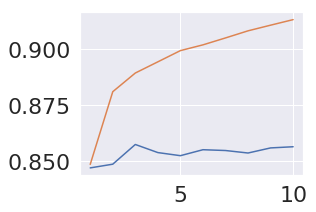

In [119]:
fig,ax = plt.subplots(figsize=(4,3))
ax.plot(np.arange(1, nb_epoch+1, 1), lstm.history["val_acc"])
ax.plot(np.arange(1, nb_epoch+1, 1), lstm.history["acc"])

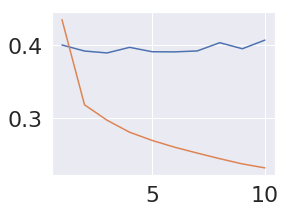

In [120]:
fig,ax = plt.subplots(figsize=(4,3))
ax.plot(np.arange(1, nb_epoch+1, 1), lstm.history["val_loss"])
ax.plot(np.arange(1, nb_epoch+1, 1), lstm.history["loss"])

Text(0.5,1,'Accuracy')

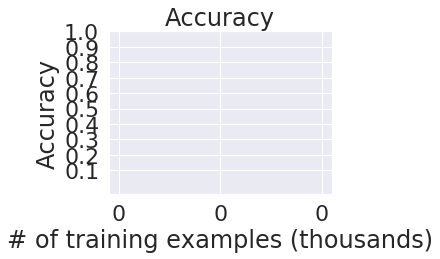

In [112]:
fig,ax = plt.subplots(figsize=(4,3))
ax.plot()
ax.set_xlabel('# of training examples (thousands)')
ax.set_ylabel('Accuracy')
ax.set_yticks(np.arange(0.1,1.1,0.1))
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_title('Accuracy')

In [100]:
lstm.history['val_acc']

[0.8468592448307817,
 0.8485197526296845,
 0.85736083851518,
 0.8537256710067128,
 0.8523344342021334,
 0.855012191182426,
 0.85465316100365,
 0.8535311978041679,
 0.8558200059094789,
 0.8563435899062344]

In [58]:
val_docs = list(tqdm(nlp.pipe(dev_texts,),total=len(dev_texts)))
val_X = get_features(val_docs,lstm_shape['max_length'])
predictM = lstm.model.predict_proba(val_X)

100%|██████████| 66847/66847 [00:00<00:00, 154779.88it/s]


In [60]:
probaDf_multI = pd.DataFrame(data = predictM, columns = le.classes_)
probaDf_multI.index = pd.MultiIndex.from_arrays([final_val_df.attribute.values, dev_texts], names=['entity','text'])
probaDf = probaDf_multI.reset_index()

In [61]:
myClasses = grouping_df.GroupName.unique()
predicted_types = probaDf.loc[:, probaDf.columns.isin(myClasses)].idxmax(axis=1)

In [62]:
print ('Accuracy:', ((probaDf.entity == predicted_types).mean()))

Accuracy: 0.8455428067078552


In [63]:
inEvalDf=probaDf_multI

In [64]:
minProbThreshold = 0.2
confidence_mask = inEvalDf.max(axis=1)>=minProbThreshold
tmpDf3 = inEvalDf.idxmax(axis=1).reset_index(name='predicted')

In [65]:
continDf=tmpDf3.groupby(['predicted','entity']).size().unstack().fillna(0)

In [66]:
le.classes_

array(['Cell type', 'Condition/Disease', 'Genotype', 'Species', 'Tissue'],
      dtype=object)

In [67]:
continDf=continDf.loc[le.classes_, le.classes_]
continDf.index=continDf.index.copy()
continDf.columns=continDf.columns.copy()
continDf.index.name='Predicted'
continDf.columns.name='Actual'
percentDf=(continDf/continDf.sum(axis=0)).T

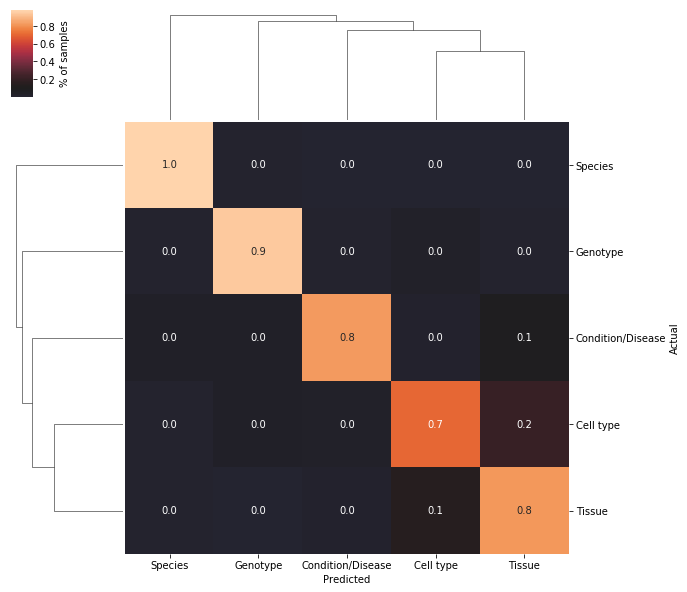

In [68]:
g=sns.clustermap(data=percentDf,annot=True,cbar_kws={'label':'% of samples'},center=0.1,
           fmt='.1f')

Text(159,0.5,'Ground truth')

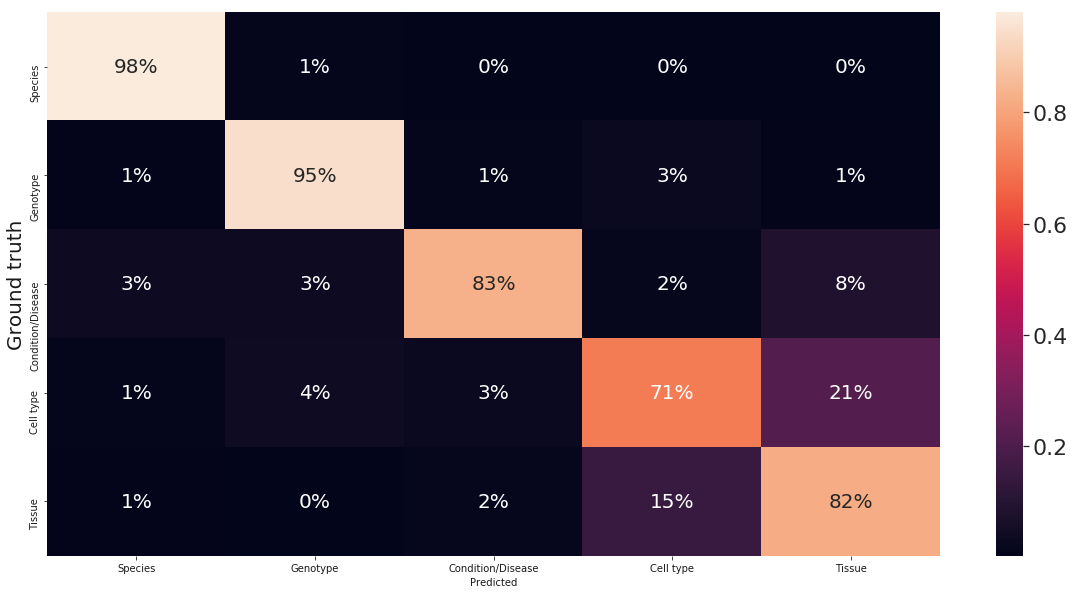

In [69]:
fig,ax=plt.subplots(figsize=(20,10))
g.data2d.columns=g.data2d.columns.copy()
g.data2d.index=g.data2d.index.copy()

#ax.set_xlabel('Predicted', fontsize = 20)
sns.set(font_scale=2)
sns.heatmap(data=percentDf.loc[g.data2d.columns,g.data2d.columns],annot=True,fmt='0.0%', annot_kws={"fontsize":20})
ax.set_ylabel('Ground truth', fontsize = 20)

In [70]:
incorrect_df = probaDf[probaDf.entity != predicted_types][['entity','text']]
incorrect_df['predicted'] = predicted_types

In [71]:
contdf_long=percentDf.stack().reset_index(name='Percent')

In [72]:
contdf_wrong=contdf_long[contdf_long.Actual!=contdf_long.Predicted].sort_values('Percent')
contdf_wrong[contdf_wrong.Percent>0.05]

,Actual,Predicted,Percent
9,Condition/Disease,Tissue,0.083543
20,Tissue,Cell type,0.149900
4,Cell type,Tissue,0.212300


{'Cell type': 0.11342242360115051,
 'Condition/Disease': 0.19407331943511963,
 'Genotype': 0.5831977725028992,
 'Species': 0.4301787465810776,
 'Tissue': 0.17998068034648895}

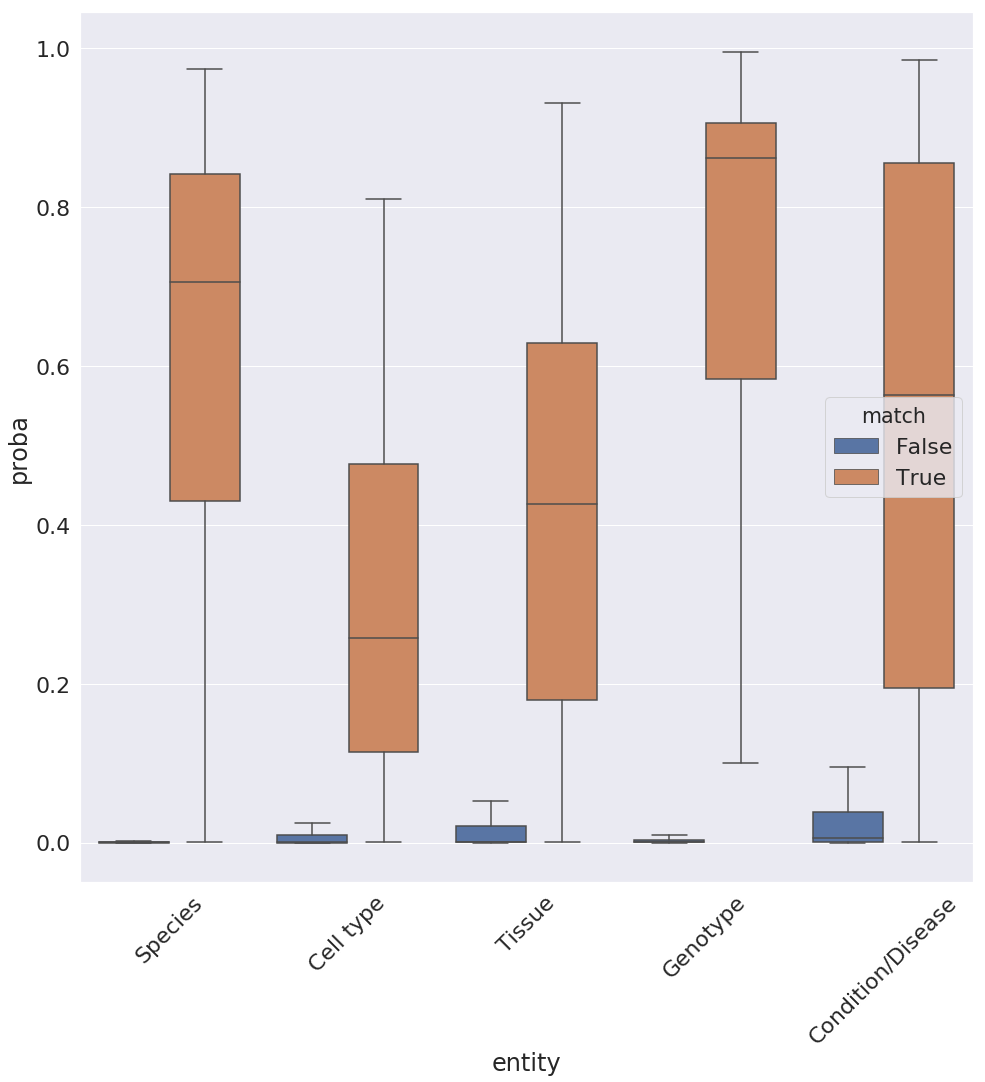

In [73]:
plt.figure(figsize=(16, 16))
predDf=probaDf_multI.stack().reset_index()
predDf.columns=['entity','text','predicted','proba']
predDf['match'] = (predDf.entity == predDf.predicted)
g =sns.boxplot(data=predDf,x='entity',y='proba', hue='match', showfliers=False)
g.set_xticklabels(g.get_xticklabels(), rotation=45)
predDf[predDf['match']].groupby(['entity'])['proba'].quantile(0.25).to_dict()

In [74]:
incorrect_df[incorrect_df['entity'] == 'Protocol']

,entity,text,predicted


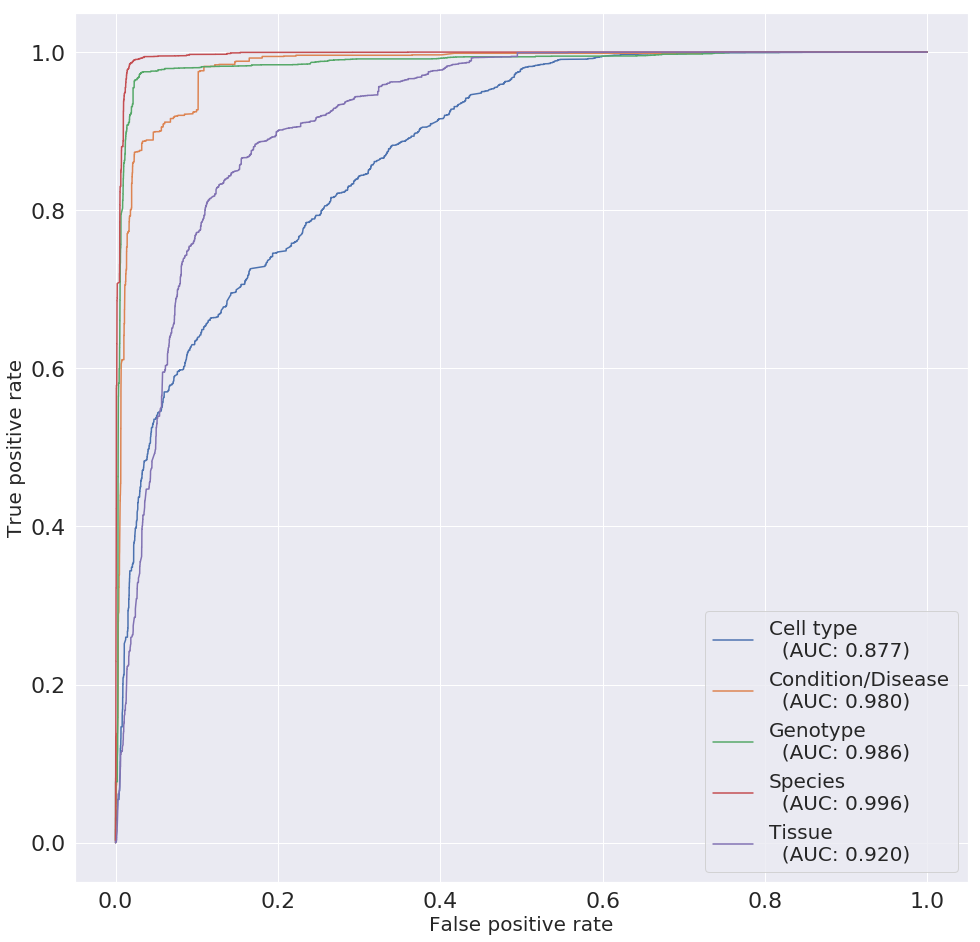

In [75]:
fig,ax=plt.subplots(figsize=(16,16))
for myClass in le.classes_: 
    fpr,tpr,_=metrics.roc_curve((probaDf.entity==myClass),probaDf[myClass])    
    ax.plot(fpr,tpr,label="{myClass}\n  (AUC: {AUC})".format(myClass=myClass,AUC=str(metrics.auc(fpr,tpr))[:5]))
ax.set_xlabel('False positive rate', fontsize = 20)
ax.set_ylabel('True positive rate', fontsize = 20)
ax.legend(fontsize=20)

In [76]:
inTmpDf=inEvalDf.idxmax(axis=1).reset_index(name='predicted')

In [77]:
inTmpDf['correct']=inTmpDf.entity==inTmpDf.predicted

In [78]:
inTmpDf.groupby('entity')['correct'].mean().sort_values()

entity
Cell type            0.710850
Tissue               0.821850
Condition/Disease    0.832411
Genotype             0.946914
Species              0.980600
Name: correct, dtype: float64

In [79]:
p_r_f1 = metrics.precision_recall_fscore_support(y_true=inTmpDf['entity'],y_pred=inTmpDf['predicted'],average='weighted')
display(pd.DataFrame({'Accuracy':lstm.history['val_acc'], 
                      'Precision':p_r_f1[0], 
                      'Recall':p_r_f1[1], 
                      'F1 Score':p_r_f1[2]}))

,Accuracy,Precision,Recall,F1 Score
0,0.845543,0.847545,0.845543,0.84453


In [80]:
probaDf

,entity,text,Cell type,Condition/Disease,Genotype,Species,Tissue
0,Species,Helicobacter pylori J99,0.000302,0.000418,0.000641,0.199307,0.000008
1,Species,Mycobacterium tuberculosis,0.000767,0.010381,0.000906,0.701931,0.000109
2,Species,Klebsiella pneumoniae,0.001029,0.000223,0.000093,0.791948,0.000057
3,Species,Staphylococcus aureus,0.000586,0.000769,0.000154,0.739052,0.000051
4,Cell type,embryonic kidney,0.150164,0.000274,0.000022,0.000039,0.248579
5,Species,Staphylococcus aureus,0.000586,0.000769,0.000154,0.739052,0.000051
6,Species,Setaria viridis,0.000411,0.000159,0.000479,0.882832,0.000034
7,Cell type,Vestibular epithelium,0.168424,0.000572,0.000091,0.000343,0.175692
8,Species,Saccharomyces uvarum,0.002128,0.000152,0.000192,0.873046,0.000030
9,Cell type,Wildtype animal heads,0.027367,0.000025,0.012102,0.000034,0.002006


In [81]:
fpr,tpr,_=metrics.roc_curve((probaDf.entity==myClass),probaDf[myClass])   

In [82]:
final_train_df[final_train_df['attribute'] == 'Sex']

,srs,attribute,value,original_attribute
